In [1]:
from dotenv import load_dotenv

load_dotenv()

True

#### Human-in-the-loop

In [2]:
import uuid

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.types import Command, interrupt

In [3]:
tavily_tool = TavilySearchResults(max_results=5)

tools = [tavily_tool]
tool_node = ToolNode(tools)

In [4]:
llm_init = ChatAnthropic(model="claude-3-haiku-20240307")
llm_final = ChatAnthropic(model="claude-3-5-sonnet-latest")

In [5]:
class AskHuman(BaseModel):
    """Pregunta al usuario"""
    
    question: str

In [6]:
llm_init = llm_init.bind_tools(tools + [AskHuman])

In [7]:
def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm_init.invoke(messages)

    return {"messages": [response]}

def call_final_model(state: MessagesState):
    messages = state["messages"]
    last_ai_message = messages[-1]


    response = llm_final.invoke([
        SystemMessage(
            """
            Genera un breve resumen de la información proporcionada en base al tema que se esta tratando.
            """
        ),
        HumanMessage(last_ai_message.content),
    ])

    response.id = last_ai_message.id

    return {"messages": [response]}

def ask_human(state: MessagesState):
    tool_call_id = state["messages"][-1].tool_calls[0]["id"]
    content = interrupt("Sobre que tema quieres saber ?")
    tool_message = [{"tool_call_id": tool_call_id, "type": "tool", "content": content}]
    return {"messages": tool_message}

def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]

    if not last_message.tool_calls:
        return "end"
    elif last_message.tool_calls[0]["name"] == "AskHuman":
        return "ask_human"
    else:
        return "tools"

In [8]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.add_node("final", call_final_model)
workflow.add_node("ask_human", ask_human)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",
        "ask_human": "ask_human",
        "end": "final",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("ask_human", "agent")
workflow.add_edge("final", END)


memory = MemorySaver()


app = workflow.compile(checkpointer=memory)

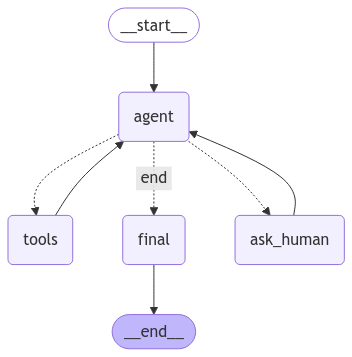

In [9]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

#### Prueba

In [10]:
thread = {"configurable": {"thread_id": uuid.uuid4()}}

In [11]:
input_message = HumanMessage(content="Pregunta al usuario qué quiere buscar, luego usa las herramientas que tengas para realizar la búsqueda")

for event in app.stream({"messages": [input_message]}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Pregunta al usuario qué quiere buscar, luego usa las herramientas que tengas para realizar la búsqueda
================================== Ai Message ==================================

[{'id': 'toolu_01D4HcgAzwH6L1wmBd9JYKfb', 'input': {'question': '¿Qué quieres buscar?'}, 'name': 'AskHuman', 'type': 'tool_use'}]
Tool Calls:
  AskHuman (toolu_01D4HcgAzwH6L1wmBd9JYKfb)
 Call ID: toolu_01D4HcgAzwH6L1wmBd9JYKfb
  Args:
    question: ¿Qué quieres buscar?


In [12]:
app.get_state(thread).next

('ask_human',)

In [13]:
for event in app.stream(
    Command(resume="Investiga sobre IA generativa"), thread, stream_mode="values"
):
    event["messages"][-1].pretty_print()


================================== Ai Message ==================================

[{'id': 'toolu_01D4HcgAzwH6L1wmBd9JYKfb', 'input': {'question': '¿Qué quieres buscar?'}, 'name': 'AskHuman', 'type': 'tool_use'}]
Tool Calls:
  AskHuman (toolu_01D4HcgAzwH6L1wmBd9JYKfb)
 Call ID: toolu_01D4HcgAzwH6L1wmBd9JYKfb
  Args:
    question: ¿Qué quieres buscar?
================================= Tool Message =================================

Investiga sobre IA generativa
================================== Ai Message ==================================

[{'id': 'toolu_017ACg1rXswSZJDNmof5WmtU', 'input': {'query': 'IA generativa'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_017ACg1rXswSZJDNmof5WmtU)
 Call ID: toolu_017ACg1rXswSZJDNmof5WmtU
  Args:
    query: IA generativa
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.ibm.com/es-es/topics/generative